In [1]:
import os

import music21
import numpy as np
from src.utils import parse_midi_files,load_parsed_files

In [2]:
# Define the paths and constants
DATA_PATH = "data/raw/"
PARSED_DATA_PATH = "data/parsed"
PARSED_SEQUENCES_DATA_PATH = "data/parsed_sequences"
VOCAB_PATH = "data/vocab"
PARSE_MIDI_FILES = False
SEQ_LEN = 50
BATCH_SIZE = 256
EMBEDDING_DIM = 128
KEY_DIM = 256
N_HEADS = 4
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256

In [3]:
# Get the list of midi files
file_names = [os.path.join(DATA_PATH,f) for f in os.listdir(DATA_PATH) if f.endswith(".mid")]
len(file_names)

36

In [4]:
# define the parser
parser = music21.converter

In [5]:
# Parse the midi files
if PARSE_MIDI_FILES:
    sequence_notes, sequence_durations = parse_midi_files(
        file_names, parser, SEQ_LEN + 1, PARSED_SEQUENCES_DATA_PATH
    )
else:
    sequence_notes, sequence_durations = load_parsed_files(PARSED_SEQUENCES_DATA_PATH)
len(sequence_notes),len(sequence_durations)

(27581, 27581)

In [6]:
example_notes = sequence_notes[658]
example_durations = sequence_durations[658]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 G3 B3 C4 G3 E3 D3 C3 E3 A3 C4 F#3 A3 C4 E4 D4 C3 B2 G3 A2 G2 D2 A2 G3 F#3 G3 G2 B2 D3 G3 B3 D4 F#4 G4 D4 B3 G3 G2 A3 A3 F#3 G3 A3 D3 E3 F#3 G3 A3 F#3 D3 C3 B2 ...

Duration string
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.75 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.75 0.25 1.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 ...


In [7]:
from src.vectorization import VectorizeLayer

# Create the vectorizer layer for notes
notes_vectorizer = VectorizeLayer(special_tokens=["[UNK]",""])
notes_vectorizer.adapt(sequence_notes)
notes_vectorizer.save_vocab(os.path.join(VOCAB_PATH,"notes_vocab.json"))

# Create the vectorizer layer for durations
durations_vectorizer = VectorizeLayer(special_tokens=["[UNK]",""])
durations_vectorizer.adapt(sequence_durations)
durations_vectorizer.save_vocab(os.path.join(VOCAB_PATH,"durations_vocab.json"))

len(notes_vectorizer.vocab),len(durations_vectorizer.vocab)

Vocab saved to data/vocab/notes_vocab.json
Vocab saved to data/vocab/durations_vocab.json


(59, 24)

In [8]:
# tokenize the notes and durations
notes_tokenized = notes_vectorizer(sequence_notes)
durations_tokenised = durations_vectorizer(sequence_durations)
notes_tokenized.shape,durations_tokenised.shape

(torch.Size([27581, 51]), torch.Size([27581, 51]))

In [9]:
from src.dataset import MusicDataset
from torch.utils.data import DataLoader

# Create a dataset and dataloader
dataset = MusicDataset(notes_tokenized,durations_tokenised,SEQ_LEN)
dataloader = DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True)
len(dataloader)

108

In [10]:
# Get a batch of data
x_note,x_duration,y_note,y_duration = next(iter(dataloader))
x_note.shape,x_duration.shape,y_note.shape,y_duration.shape

(torch.Size([256, 50]),
 torch.Size([256, 50]),
 torch.Size([256, 50]),
 torch.Size([256, 50]))

In [11]:
from src.embedding import TokenAndPositionEmbedding

# Define the embedding layers
embed_notes_layer = TokenAndPositionEmbedding(notes_vectorizer.vocab_size,embed_dim=128)
embed_durations_layer = TokenAndPositionEmbedding(durations_vectorizer.vocab_size,embed_dim=128)


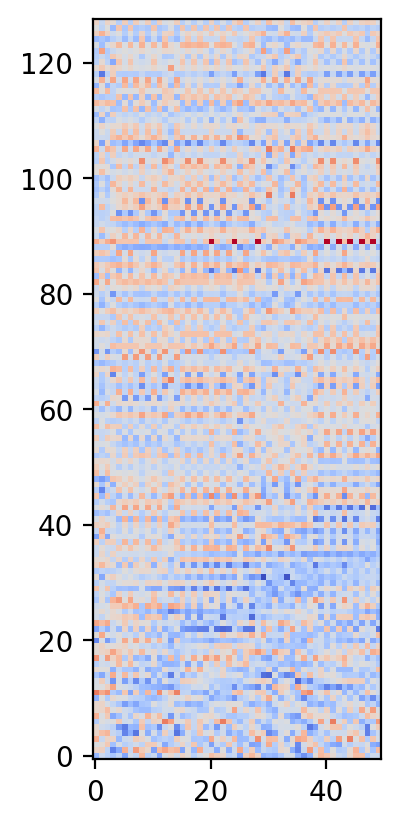

In [12]:
import matplotlib.pyplot as plt

# visualize the embedding layers
embedding_example = embed_notes_layer(x_note)

plt.imshow(
    np.transpose(embedding_example.detach().numpy()[0]),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

In [13]:
from torch import nn
import torch

from src.transformer_block import TransformerBlock

class MusicModel(nn.Module):
    def __init__(self, notes_vocab_size, durations_vocab_size):
        super(MusicModel, self).__init__()
        self.notes_embedding = TokenAndPositionEmbedding(len(notes_vectorizer.vocab), embed_dim=EMBEDDING_DIM//2)
        self.durations_embedding = TokenAndPositionEmbedding(len(durations_vectorizer.vocab), embed_dim=EMBEDDING_DIM//2)
        self.block = TransformerBlock(N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, DROPOUT_RATE)
        self.out_note = nn.Linear(EMBEDDING_DIM, notes_vocab_size)
        self.out_duration = nn.Linear(EMBEDDING_DIM, durations_vocab_size)

        # Ajout d'une couche de normalisation
        self.layer_norm = nn.LayerNorm(EMBEDDING_DIM)

    def _check_tensor(self, tensor, name):
        if torch.isnan(tensor).any():
            print(f"NaN détecté dans {name}")
            print(f"Stats {name}:", {
                "min": torch.min(tensor).item(),
                "max": torch.max(tensor).item(),
                "mean": torch.mean(tensor).item(),
                "std": torch.std(tensor).item()
            })
            return False
        return True

    def forward(self, note, duration):
        # Vérification des entrées
        self._check_tensor(note, "note input")
        self._check_tensor(duration, "duration input")

        # Embeddings
        note_embedding = self.notes_embedding(note)
        if not self._check_tensor(note_embedding, "note_embedding"):
            raise ValueError("NaN in note_embedding")
        print("Note embedding shape:", note_embedding.shape)

        duration_embedding = self.durations_embedding(duration)
        if not self._check_tensor(duration_embedding, "duration_embedding"):
            raise ValueError("NaN in duration_embedding")
        print("Duration embedding shape:", duration_embedding.shape)

        # Concaténation
        x = torch.cat([note_embedding, duration_embedding], dim=-1)
        print("After concatenation shape:", x.shape)

        # Normalisation après concaténation
        x = self.layer_norm(x)
        if not self._check_tensor(x, "after normalization"):
            raise ValueError("NaN after normalization")

        # Transformer block
        x, attention_score = self.block(x)
        if not self._check_tensor(x, "after transformer block"):
            raise ValueError("NaN after transformer block")
        if not self._check_tensor(attention_score, "attention scores"):
            raise ValueError("NaN in attention scores")

        # Sorties
        out_note = self.out_note(x)
        if not self._check_tensor(out_note, "before note softmax"):
            raise ValueError("NaN before note softmax")
        out_note = torch.softmax(out_note, dim=-1)

        out_duration = self.out_duration(x)
        if not self._check_tensor(out_duration, "before duration softmax"):
            raise ValueError("NaN before duration softmax")
        out_duration = torch.softmax(out_duration, dim=-1)

        return out_note, out_duration, attention_score

In [14]:
# Create the model
x_note,x_duration,y_note,y_duration = next(iter(dataloader))

model = MusicModel(notes_vectorizer.vocab_size,durations_vectorizer.vocab_size)
out_note,out_duration,att_score = model(x_note,x_duration)
out_note.shape,out_duration.shape,att_score.shape

Note embedding shape: torch.Size([256, 50, 64])
Duration embedding shape: torch.Size([256, 50, 64])
After concatenation shape: torch.Size([256, 50, 128])
NaN détecté dans after transformer block
Stats after transformer block: {'min': nan, 'max': nan, 'mean': nan, 'std': nan}


ValueError: NaN after transformer block

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

In [17]:

for epoch in range(1):
    for x_note, x_duration, y_note, y_duration in dataloader: # [256, 50],[256, 50],[256, 50],[256, 50]
        optimizer.zero_grad()

        # Prédiction
        out_note, out_duration, att_score = model(x_note, x_duration)# [256, 50, 59],[256, 50, 24],[256, 50, 50]

        out_note = out_note.view(-1, notes_vectorizer.vocab_size)        # [256*50, 59]
        out_duration = out_duration.view(-1, durations_vectorizer.vocab_size)  # [256*50, 24]
        y_note = y_note.view(-1)                             # [256*50]
        y_duration = y_duration.view(-1)                     # [256*50]

        loss_note = loss_fn(out_note, y_note)
        loss_duration = loss_fn(out_duration, y_duration)
        total_loss_batch = loss_note + loss_duration

        total_loss_batch.backward()
        optimizer.step()

        print(loss_note.item(),loss_duration.item())
        #print(total_loss_batch.item())
        break


nan nan


In [18]:
out_note

tensor([[-0.2013,  0.0131, -1.0662,  ...,  0.6213,  0.2947, -0.0314],
        [-0.1999,  0.2385, -0.8594,  ...,  0.5496,  0.1244, -0.8474],
        [-0.7025,  0.4220, -0.0094,  ...,  1.3045,  0.6865,  0.1591],
        ...,
        [-0.2118, -0.0755, -0.8148,  ...,  1.0052, -0.3608, -0.1908],
        [ 0.1442, -0.1133,  0.2075,  ...,  0.3368,  0.3317, -0.2434],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan]],
       grad_fn=<ViewBackward0>)

In [19]:
torch.isnan(out_note).any()


tensor(True)

In [24]:
torch.nonzero(torch.isnan(out_note), as_tuple=True)

(tensor([   49,    49,    49,  ..., 12799, 12799, 12799]),
 tensor([ 0,  1,  2,  ..., 56, 57, 58]))